# Model Report

In [1]:
import re
import warnings
from pathlib import Path
from time import time
from typing import Dict, List

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotnine as gg
import pymc3 as pm
import seaborn as sns
from src.command_line_interfaces import simulation_based_calibration_cli as sbc_cli
from src.context_managers import set_directory
from src.data_processing import common as dphelp
from src.modeling import pymc3_analysis as pmanal
from src.modeling import pymc3_sampling_api as pmapi
from src.modeling import sampling_pymc3_models as sampling
from src.modeling.sampling_pymc3_models import SamplingArguments
from src.modeling.simulation_based_calibration_helpers import SBCFileManager
from src.plot.color_pal import SeabornColor

notebook_tic = time()

warnings.simplefilter(action="ignore", category=UserWarning)

gg.theme_set(gg.theme_classic())
%config InlineBackend.figure_format = "retina"

RANDOM_SEED = 847
np.random.seed(RANDOM_SEED)

pymc3_cache_dir = Path("..", "models", "modeling_cache", "pymc3_model_cache")

Parameters for papermill:

- `MODEL`: which model was tested
- `SBC_RESULTS_DIR`: directory containing results of many rounds of SBC
- `NUM_SIMULATIONS`: the number of simiulations; will be used to check that all results are found

## Setup

### Papermill parameters

In [2]:
MODEL = ""
SBC_RESULTS_DIR = ""
NUM_SIMULATIONS = -1

In [3]:
# Parameters
MODEL = "crc_model_one"
SBC_RESULTS_DIR = "temp/crc_model_one"
NUM_SIMULATIONS = 20

### Prepare and validate papermill parameters

Build the model using the `MODEL` parameter.

In [4]:
ModelClass = sbc_cli.get_model_class(sbc_cli.ModelOption[MODEL])

Check values passed as the directory with results of the rounds of SBC.

In [5]:
sbc_results_dir = Path("../..", SBC_RESULTS_DIR)
assert sbc_results_dir.is_dir()
assert sbc_results_dir.exists()

Confirm that there is a positive number of simulations.

In [6]:
assert NUM_SIMULATIONS > 0

## Read in all results

In [7]:
def split_parameter(p: str) -> List[str]:
    return [a for a in re.split("\\[|,|\\]", p) if a != ""]


def get_prior_value_using_index_list(ary: np.ndarray, idx: List[int]) -> float:
    if len(idx) == 0:
        return ary

    assert len(idx) == len(ary.shape)
    value = ary
    for i in idx:
        value = value[i]
    return value


def make_priors_dataframe(
    priors: Dict[str, np.ndarray], parameters: List[str]
) -> pd.DataFrame:
    df = pd.DataFrame({"parameter": parameters, "true_value": 0}).set_index("parameter")
    for parameter in parameters:
        split_p = split_parameter(parameter)
        param = split_p[0]
        idx = [int(i) for i in split_p[1:]]
        value = get_prior_value_using_index_list(priors[param][0], idx)
        df.loc[parameter] = value
    return df

In [8]:
simulation_posteriors = []

for sbc_dir in sbc_results_dir.iterdir():
    sbc_fm = SBCFileManager(sbc_dir)
    if not sbc_fm.all_data_exists():
        raise Exception(f"Not all output from '{sbc_fm.dir.name}' exist.")
    res = sbc_fm.get_sbc_results()
    true_values = make_priors_dataframe(
        res.priors, parameters=res.posterior_summary.index.values
    )
    posterior_summary = res.posterior_summary.merge(
        true_values, left_index=True, right_index=True
    )
    simulation_posteriors.append(posterior_summary)

In [9]:
if len(simulation_posteriors) == NUM_SIMULATIONS:
    print("Collected all simulations.")
else:
    print(
        f"The number of simluations ({NUM_SIMULATIONS}) does not match the number collected ({len(simulation_posteriors)})."
    )

Collected all simulations.


## Analysis

In [10]:
def measure_posterior_accuracy(post) -> float:
    hdi_lower = post.iloc[:, 2].values.flatten()
    hdi_upper = post.iloc[:, 3].values.flatten()
    trues = post["true_value"].values.flatten()
    return np.mean((hdi_lower < trues).astype(int) * (trues < hdi_upper).astype(int))

In [11]:
hdi_acc = [measure_posterior_accuracy(p) for p in simulation_posteriors]

Text(0.5, 0, 'HDI accuracy')

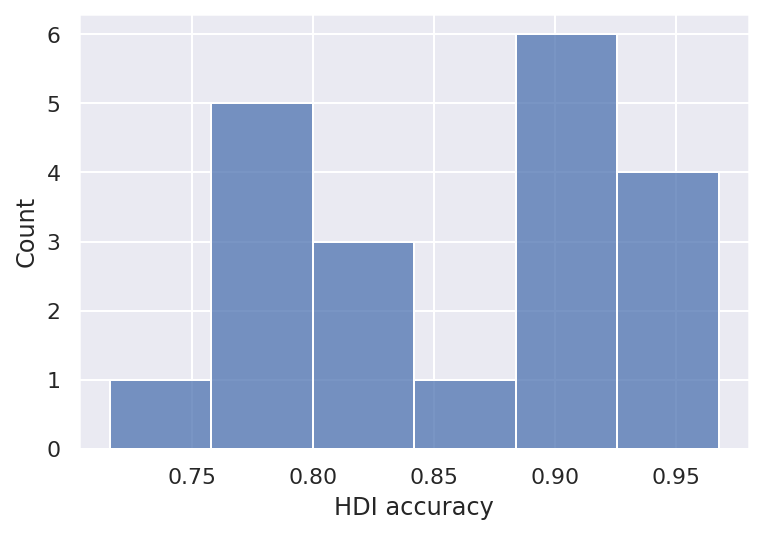

In [12]:
sns.set_theme()
ax = sns.histplot(hdi_acc)
ax.set_xlabel("HDI accuracy");

---

In [13]:
notebook_toc = time()
print(f"execution time: {(notebook_toc - notebook_tic) / 60:.2f} minutes")

execution time: 0.13 minutes


In [14]:
%load_ext watermark
%watermark -d -u -v -iv -b -h -m

Last updated: 2021-04-02

Python implementation: CPython
Python version       : 3.9.2
IPython version      : 7.21.0

Compiler    : GCC 9.3.0
OS          : Linux
Release     : 3.10.0-1062.el7.x86_64
Machine     : x86_64
Processor   : x86_64
CPU cores   : 28
Architecture: 64bit

Hostname: compute-e-16-233.o2.rc.hms.harvard.edu

Git branch: simulation-based-calibration

numpy     : 1.20.1
arviz     : 0.11.2
seaborn   : 0.11.1
matplotlib: 3.3.4
plotnine  : 0.7.1
pymc3     : 3.11.1
re        : 2.2.1
pandas    : 1.2.3

